# House Prices: Advanced Regression Techniques

__Excerpt from competition page__<br>
...With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

__Practice Skills:__
-  Creative feature engineering 
-  Advanced regression techniques like random forest and gradient boosting


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-and-Import" data-toc-modified-id="Setup-and-Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup and Import</a></span><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Utility Functions</a></span></li><li><span><a href="#High-Level-View" data-toc-modified-id="High-Level-View-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>High Level View</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Fix-NA-Import" data-toc-modified-id="Fix-NA-Import-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Fix NA Import</a></span></li></ul></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Missing-Data" data-toc-modified-id="Missing-Data-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Missing Data</a></span></li></ul></li><li><span><a href="#Encode-Categorical-Data" data-toc-modified-id="Encode-Categorical-Data-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Encode Categorical Data</a></span></li><li><span><a href="#Normalization" data-toc-modified-id="Normalization-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Normalization</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Simple-Model-Generation-and-Comparison" data-toc-modified-id="Simple-Model-Generation-and-Comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simple Model Generation and Comparison</a></span></li></ul></div>

## Setup and Import 

### Import

In [2]:
#Imports
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

pd.set_option("display.max_columns",100)
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
y_train = train_data["SalePrice"]


### Utility Functions

In [3]:
def plot_ann_barh(series, xlim=None, title=None, size=(12,6)):
    """Return axes for a barh chart from pandas Series"""
    #required imports
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    #setup default values when necessary
    if xlim == None: xlim=series.max()
    if title == None: 
        if series.name == None: title='Title is required'
        else: title=series.name
    
    #create barchart
    ax = series.plot(kind='barh', title=title, xlim=(0,xlim), figsize=size, grid=False)
    sns.despine(left=True)
    
    #add annotations
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()+(xlim*0.01), i.get_y()+.38, \
                str(i.get_width()), fontsize=10,
    color='dimgrey')
    
    #the invert will order the data as it is in the provided pandas Series
    plt.gca().invert_yaxis()
    
    return ax

### High Level View

Will combine train/test sets into single dataframe for data cleaning and missing value imputation steps. Then will split them back out later.

In [4]:
test_data_idx = len(train_data)
combined_df = pd.concat([train_data.set_index("Id").drop("SalePrice", axis=1),test_data.set_index("Id")])
quantitative = [f for f in combined_df.columns if combined_df.dtypes[f] != 'object']
qualitative = [f for f in combined_df.columns if combined_df.dtypes[f] == 'object']

In [5]:
print("Training set has {:d} rows and {:d} features.".format(train_data.shape[0],train_data.shape[1]))
print("Test set has {:d} rows and {:d} features.".format(test_data.shape[0],test_data.shape[1]))
print("Combined set has {:d} rows and {:d} features.".format(combined_df.shape[0],combined_df.shape[1]))
print("Quantitative features: ")
print(quantitative)
print("Qualitative features: ")
print(qualitative)

Training set has 1460 rows and 81 features.
Test set has 1459 rows and 80 features.
Combined set has 2919 rows and 79 features.
Quantitative features: 
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Qualitative features: 
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFi

### Data Cleaning

#### Fix NA Import

"NA" is used in many features to specify the property doesn't have that feature (ex. PoolQC = NA means "No Pool". But Pandas interprets NA as missing data (NaN)). So let's rename them...

In [6]:
valid_na_features = ["Alley", 
                     "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
                     "FireplaceQu", 
                     "GarageType","GarageFinish", "GarageQual", "GarageCond", 
                     "PoolQC", 
                     "Fence",
                     "MiscFeature"]
na_feature_replace = ["NoAlley", 
                     "NoBsmt", "NoBsmt", "NoBsmt", "NoBsmt", "NoBsmt", 
                     "NoFireplace", 
                     "NoGarage","NoGarage", "NoGarage", "NoGarage", 
                     "NoPool", 
                     "NoFence",
                     "NoMiscFeature"]
for col,ft_replace in zip(valid_na_features,na_feature_replace):
    combined_df[col].fillna(ft_replace, inplace = True)
    combined_df[col].fillna(ft_replace, inplace = True)
    

### Data Preprocessing

#### Missing Data


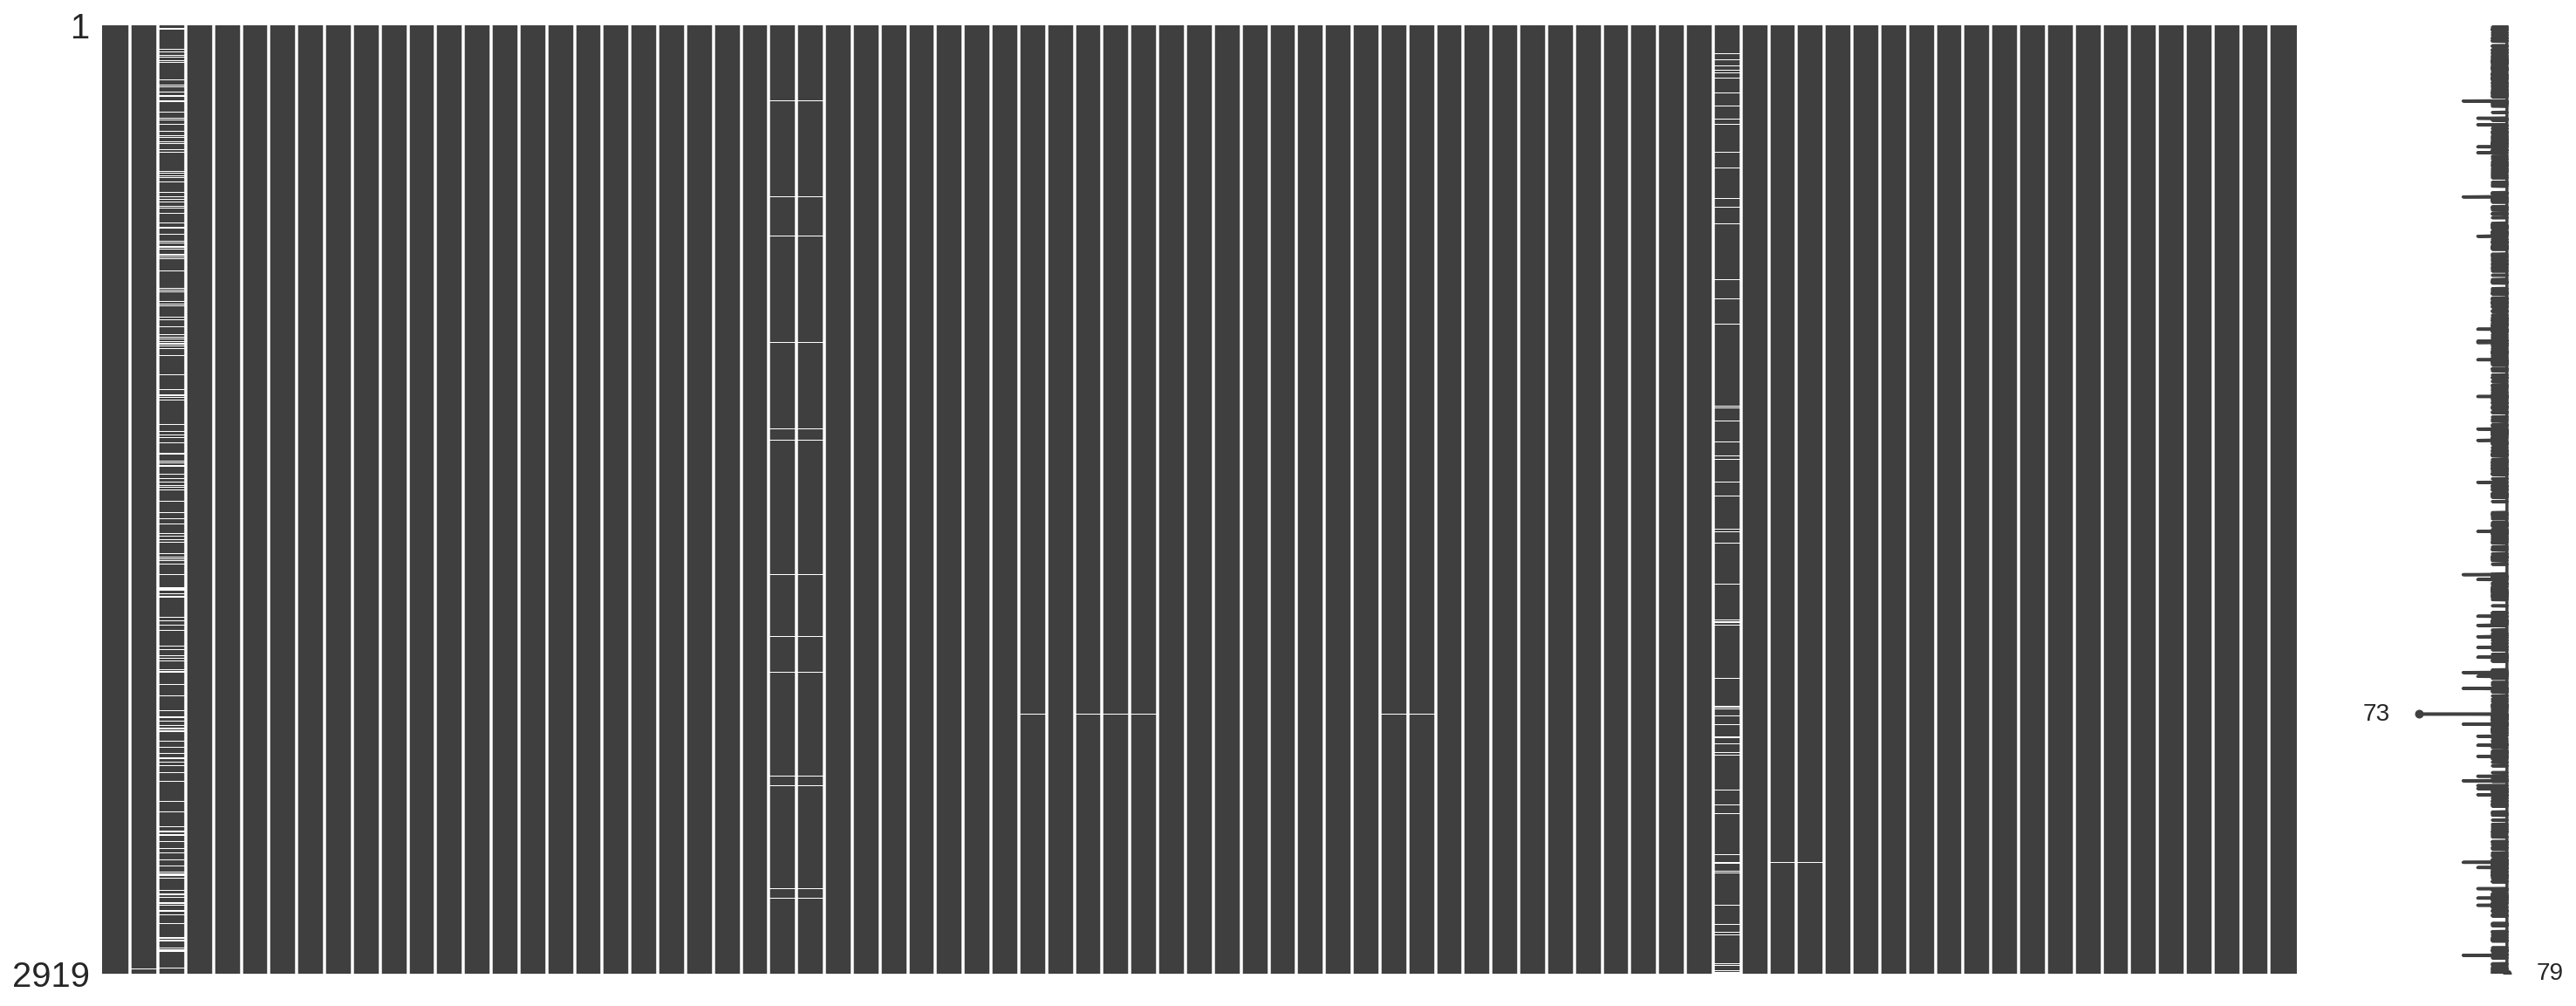

In [7]:
# Show distribution of missing data
msno.matrix(combined_df)

Not bad...

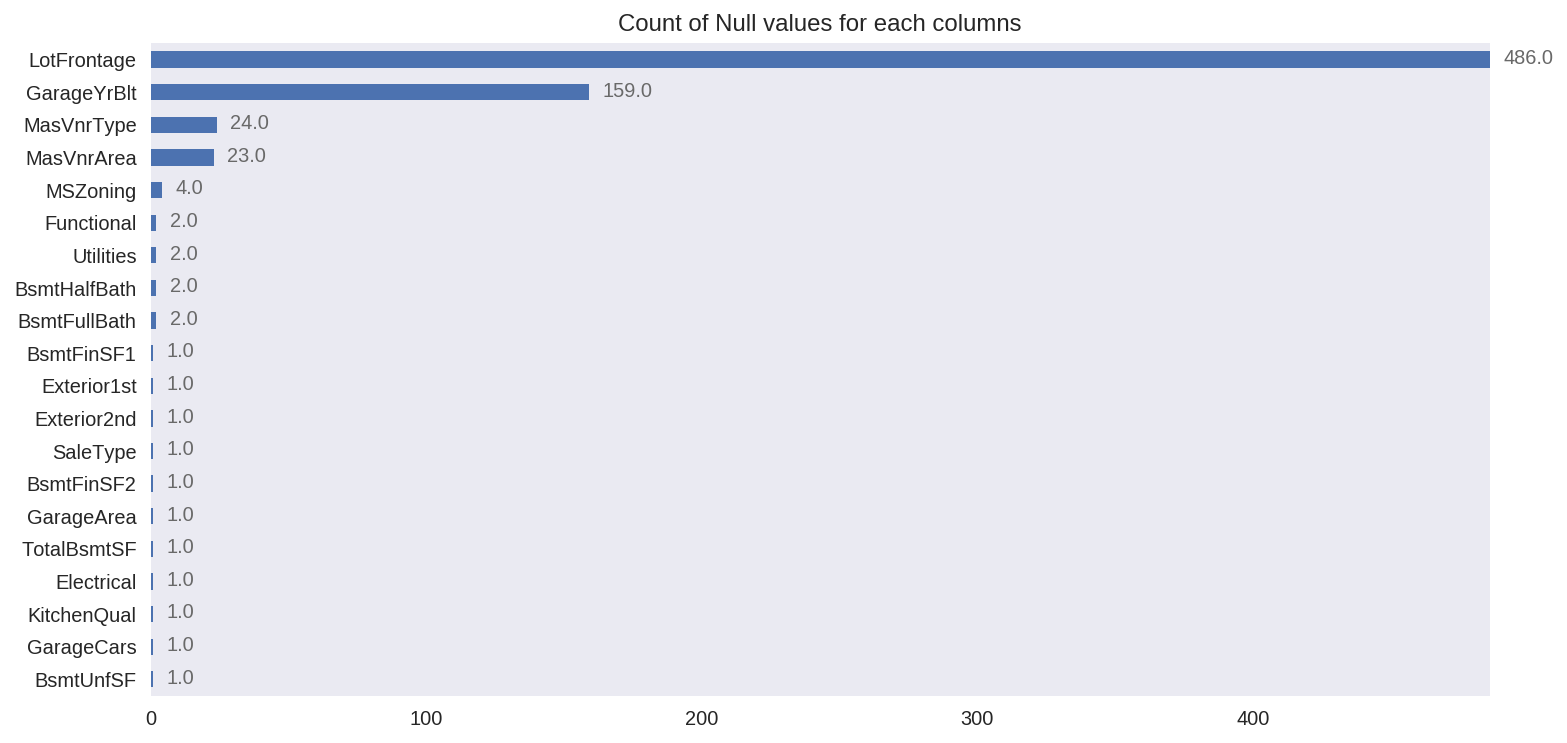

In [8]:
missing_cnt = combined_df.isnull().sum()
# Show only columns with non-zero null counts
missing = missing_cnt[missing_cnt > 0] 
# plot series result
ax = plot_ann_barh(missing.sort_values(ascending=False), 
                   xlim=max(missing), title='Count of Null values for each columns')

LotFrontage has the highest # of missing values, will deal with this one last. Most of the others can be imputed easily.

In [9]:
# BsmtUnfSF, BsmtFinSF2, TotalBsmtSF, BsmtFinSF1
combined_df.loc[combined_df[["BsmtUnfSF","BsmtFinSF2","TotalBsmtSF","BsmtFinSF1","BsmtFullBath","BsmtHalfBath"]].isnull().any(axis=1),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,NoAlley,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NoBsmt,NoBsmt,NoBsmt,NoBsmt,NaN,NoBsmt,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NoFireplace,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,4,2008,ConLD,Abnorml
2189,20,RL,123.0,47007,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,7,2008,WD,Normal


In [10]:
# 2 properties with basement features need to be imputed; both don't have a basement, so that's easy!
combined_df["BsmtUnfSF"].fillna(0, inplace=True)
combined_df["BsmtFinSF1"].fillna(0, inplace=True)
combined_df["BsmtFinSF2"].fillna(0, inplace=True)
combined_df["TotalBsmtSF"].fillna(0, inplace=True)
combined_df["BsmtFullBath"].fillna(0, inplace=True)
combined_df["BsmtHalfBath"].fillna(0, inplace=True)
# check the result
#combined_df.loc[combined_df[["BsmtUnfSF","BsmtFinSF2","TotalBsmtSF","BsmtFinSF1","BsmtFullBath","BsmtHalfBath"]].isnull().any(axis=1),:]

In [11]:
# GarageCars, GarageArea
combined_df.loc[combined_df[["GarageCars","GarageArea"]].isnull().any(axis=1),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2577,70,RM,50.0,9060,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NoFireplace,Detchd,NaN,NoGarage,NaN,NaN,NoGarage,NoGarage,Y,174,0,212,0,0,0,NoPool,MnPrv,NoMiscFeature,0,3,2007,WD,Alloca


In [12]:
# The property doesn't have a garage but GarageType is set to detached. Need to fix this one also.
# Should scrub the entire dataset and make sure other features aren't labeled incorrectly like this.
combined_df.loc[combined_df[["GarageCars","GarageArea"]].isnull().any(axis=1),"GarageType"] = "NoGarage"
combined_df["GarageCars"].fillna(0, inplace=True)
combined_df["GarageArea"].fillna(0, inplace=True)
#combined_df.loc[combined_df[["GarageCars","GarageArea"]].isnull().any(axis=1),:]

In [13]:
# KitchenQual
combined_df.loc[combined_df["KitchenQual"].isnull(),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1556,50,RL,72.0,10632,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,NoFireplace,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,NoPool,NoFence,NoMiscFeature,0,1,2010,COD,Normal


In [14]:
# look at other properties in the same neighborhood with same overall quality to impute KitchenQual
combined_df.loc[(combined_df["Neighborhood"] == "ClearCr") & 
                (combined_df["OverallQual"].between(4,6)) & 
                (combined_df["YearRemodAdd"].between(1945,1960)),
                ("OverallQual","OverallCond","YearRemodAdd","KitchenQual","GarageQual","ExterQual","BsmtQual","FireplaceQu","PoolQC","Fence")]

,OverallQual,OverallCond,YearRemodAdd,KitchenQual,GarageQual,ExterQual,BsmtQual,FireplaceQu,PoolQC,Fence
Id,,,,,,,,,,
359,5,4,1958,Gd,TA,TA,TA,NoFireplace,NoPool,NoFence
372,4,4,1959,TA,TA,TA,NoBsmt,Gd,NoPool,NoFence
1555,5,5,1959,TA,TA,TA,Gd,Gd,NoPool,NoFence
1556,5,3,1950,NaN,Fa,TA,Gd,NoFireplace,NoPool,NoFence
1847,5,5,1956,TA,TA,TA,TA,TA,NoPool,NoFence
2147,5,3,1960,TA,TA,TA,TA,TA,NoPool,NoFence


In [15]:
# Most properties similar to this based on the matching criteria are in Gd/TA quality. Choose TA since that's more typical.
combined_df["KitchenQual"].fillna("TA", inplace = True)

In [16]:
# SaleType
combined_df.loc[combined_df["SaleType"].isnull(),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2490,20,RL,85.0,13770,Pave,NoAlley,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,10,2007,NaN,Normal


In [17]:
# Check out other properties sold in same year
combined_df.loc[combined_df["YrSold"] == 2007,"SaleType"].value_counts()

WD       568
New       89
COD       18
CWD       11
Oth        2
ConLw      2
Con        1
Name: SaleType, dtype: int64

In [18]:
# Check out the "other" saletypes for fun... Maybe the NaN should be Other...
combined_df.loc[(combined_df["YrSold"] == 2007) & (combined_df["SaleType"] == "Oth"),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
943,90,RL,42.0,7711,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,3,1977,1977,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,1440.0,Unf,0.0,0.0,1440.0,GasA,TA,Y,SBrkr,1440,0,0,1440,2.0,0.0,2,0,4,2,TA,8,Typ,0,NoFireplace,NoGarage,NaN,NoGarage,0.0,0.0,NoGarage,NoGarage,N,321,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,8,2007,Oth,Abnorml
1132,20,RL,63.0,10712,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,5,1991,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Mn,BLQ,212.0,Unf,0.0,762.0,974.0,GasA,TA,Y,SBrkr,974,0,0,974,0.0,0.0,1,0,3,1,TA,5,Typ,0,NoFireplace,NoGarage,NaN,NoGarage,0.0,0.0,NoGarage,NoGarage,Y,0,28,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,9,2007,Oth,Abnorml


In [19]:
# Both "Other" saletypes are abnormal, while the NaN property has normal salecondition. Are all "other" saletypes abnormal?
combined_df.loc[combined_df["SaleType"] == "Oth","SaleCondition"].value_counts()

Abnorml    5
Family     1
Normal     1
Name: SaleCondition, dtype: int64

In [20]:
# "Other" SaleType is pretty rare and most are "abnormal" SaleCondition. 
# Probably using the most common SaleType with Normal SaleCondition from 2007 would be best guess.
combined_df.loc[(combined_df["YrSold"] == 2007) & (combined_df["SaleCondition"] == "Normal"),"SaleType"].value_counts()

WD       529
COD       11
CWD       10
Con        1
ConLw      1
Name: SaleType, dtype: int64

In [21]:
combined_df["SaleType"].fillna("WD", inplace = True)

In [22]:
# Exterior1st, Exterior2nd
combined_df.loc[combined_df[["Exterior1st","Exterior2nd"]].isnull().any(axis=1),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2152,30,RL,85.0,19550,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,NoGarage,NaN,NoGarage,0.0,0.0,NoGarage,NoGarage,Y,0,39,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,1,2008,WD,Normal


In [23]:
# OK, look at other houses in the neighborhood, built around same time, with a recent remodel
combined_df.loc[(combined_df["Neighborhood"] == "Edwards") &
                (combined_df["YearBuilt"].between(1935,1950)) &
                (combined_df["YearRemodAdd"] > 1995),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
166,190,RL,62.0,10106,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,1.5Fin,5,7,1940,1999,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,ALQ,351.0,Rec,181.0,112.0,644.0,GasA,Gd,Y,SBrkr,808,547,0,1355,1.0,0.0,2,0,4,2,TA,6,Typ,0,NoFireplace,NoGarage,NaN,NoGarage,0.0,0.0,NoGarage,NoGarage,Y,140,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,9,2008,WD,Normal
176,20,RL,84.0,12615,Pave,NoAlley,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,7,1950,2001,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,CBlock,TA,Gd,Av,ALQ,477.0,Unf,0.0,725.0,1202.0,GasA,TA,Y,SBrkr,2158,0,0,2158,1.0,0.0,2,0,4,1,Gd,7,Typ,1,Gd,Attchd,1950.0,Unf,2.0,576.0,TA,TA,Y,0,29,39,0,0,0,NoPool,MnPrv,NoMiscFeature,0,6,2007,WD,Normal
293,50,RL,60.0,11409,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,4,1949,2008,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,LwQ,292.0,Unf,0.0,476.0,768.0,GasA,Gd,Y,SBrkr,1148,568,0,1716,0.0,0.0,1,1,3,1,TA,8,Min2,1,Gd,Attchd,1949.0,Unf,1.0,281.0,TA,TA,Y,0,0,0,0,160,0,NoPool,NoFence,NoMiscFeature,0,1,2009,WD,Normal
554,20,RL,67.0,8777,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,4,5,1949,2003,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,1126,0,0,1126,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NoFireplace,Detchd,2002.0,Fin,2.0,520.0,TA,TA,N,0,96,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,5,2009,WD,Normal
608,20,RL,78.0,7800,Pave,NoAlley,Reg,Bnk,AllPub,Inside,Mod,Edwards,Norm,Norm,1Fam,2Story,5,8,1948,2002,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,Gd,No,GLQ,603.0,Unf,0.0,293.0,896.0,GasA,Ex,Y,SBrkr,1112,896,0,2008,1.0,0.0,3,0,3,1,Ex,8,Typ,0,NoFireplace,Attchd,1948.0,Unf,1.0,230.0,TA,TA,Y,103,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,8,2006,WD,Normal
1050,20,RL,60.0,11100,Pave,NoAlley,Reg,Low,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,7,1946,2006,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,930,0,0,930,0.0,0.0,1,0,2,1,Gd,6,Typ,0,NoFireplace,Detchd,1946.0,Unf,1.0,308.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2010,WD,Abnorml
1124,20,RL,50.0,9405,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,9,1947,2008,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,Ex,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,698.0,698.0,GasA,Ex,Y,SBrkr,698,0,0,698,0.0,1.0,1,0,2,1,TA,4,Typ,0,NoFireplace,NoGarage,NaN,NoGarage,0.0,0.0,NoGarage,NoGarage,Y,0,200,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2009,WD,Normal
1586,30,RL,67.0,8777,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Mod,Edwards,Feedr,Norm,1Fam,1Story,3,6,1945,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,TA,N,SBrkr,640,0,0,640,0.0,0.0,1,0,2,1,TA,5,Min1,0,NoFireplace,Detchd,1945.0,Unf,1.0,240.0,TA,TA,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2010,ConLD,Normal
2152,30,RL,85.0,19550,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0

In [24]:
# What about with same rooftype...
#(combined_df["Neighborhood"] == "Edwards") &
#(combined_df["YearBuilt"].between(1935,1950)) &
                                

combined_df.loc[(combined_df["RoofStyle"] == "Flat") &
                (combined_df["RoofMatl"] == "Tar&Grv"),"Exterior2nd"].value_counts()

Plywood    8
Wd Sdng    4
Wd Shng    2
CBlock     1
Brk Cmn    1
Name: Exterior2nd, dtype: int64

In [25]:
# Plywood is most common exterior for houses with this type of roof, so will go with that as best guess...
combined_df["Exterior1st"].fillna("Plywood", inplace = True)
combined_df["Exterior2nd"].fillna("Plywood", inplace = True)

In [26]:
# Utilities
combined_df.loc[combined_df[["Utilities"]].isnull().any(axis=1),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1916,30,NaN,109.0,21780,Grvl,NoAlley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NoFireplace,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2009,ConLD,Normal
1946,20,RL,NaN,31220,Pave,NoAlley,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,NoPool,NoFence,Shed,750,5,2008,WD,Normal


In [27]:
# Both have gas heating, 2nd has AC, both have electrical. Look at other houses in the neighborhoods.
print(combined_df.loc[(combined_df["Neighborhood"] == "IDOTRR"),"Utilities"].value_counts())
print(combined_df.loc[(combined_df["Neighborhood"] == "Gilbert"),"Utilities"].value_counts())

AllPub    92
Name: Utilities, dtype: int64
AllPub    164
Name: Utilities, dtype: int64


In [28]:
# both neighborhoods have "AllPub" utilities for all properties, so impute with that value.
combined_df["Utilities"].fillna("AllPub", inplace = True)

In [29]:
# Functional
combined_df.loc[combined_df[["Functional"]].isnull().any(axis=1),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2217,20,NaN,80.0,14584,Pave,NoAlley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NoFireplace,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2008,WD,Abnorml
2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,NoFireplace,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,NoPool,NoFence,NoMiscFeature,0,9,2007,COD,Abnorml


In [30]:
# both properties have abnormal salecondition so let's look at other properties w/ this condition.
combined_df.loc[(combined_df["SaleCondition"] == "Abnorml") & 
                (combined_df["OverallQual"].between(4,6)),
                ("Functional","SaleType","GarageQual","BsmtQual","ExterQual","OverallQual","OverallCond")]

,Functional,SaleType,GarageQual,BsmtQual,ExterQual,OverallQual,OverallCond
Id,,,,,,,
20,Min1,COD,TA,TA,TA,5,6
39,Typ,WD,TA,TA,TA,5,7
41,Typ,WD,TA,TA,TA,6,5
92,Typ,WD,TA,TA,TA,5,3
99,Typ,COD,Fa,TA,TA,5,5
114,Typ,COD,TA,Gd,TA,6,5
130,Typ,WD,TA,TA,TA,5,7
145,Typ,ConLI,TA,TA,TA,5,5
199,Typ,WD,NoGarage,TA,TA,6,6


In [31]:
combined_df.loc[(combined_df["SaleCondition"] == "Abnorml") & (combined_df["OverallQual"] < 6),"Functional"].value_counts()

Typ     92
Min2     5
Mod      4
Min1     3
Maj2     2
Sev      1
Name: Functional, dtype: int64

In [32]:
# Seems safe to use Typ for Imputing missing "functional" features
combined_df["Functional"].fillna("Typ", inplace = True)

In [33]:
# MsZoning
combined_df.loc[combined_df[["MSZoning"]].isnull().any(axis=1),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1916,30,NaN,109.0,21780,Grvl,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NoFireplace,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2009,ConLD,Normal
2217,20,NaN,80.0,14584,Pave,NoAlley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,NoFireplace,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2008,WD,Abnorml
2251,70,NaN,NaN,56600,Pave,NoAlley,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NoFireplace,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,1,2008,WD,Normal
2905,20,NaN,125.0,31250,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NoFireplace,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2006,WD,Normal


In [34]:
# Check out the zoning for other properties in the neighborhoods.
combined_df.loc[(combined_df["Neighborhood"] == "IDOTRR","MSZoning")].value_counts()

RM         68
C (all)    22
Name: MSZoning, dtype: int64

In [35]:
# These are all residential properties so the missing zoning should be RM since all other residentials in IDOTRR are RM.
combined_df.loc[((combined_df["Neighborhood"] == "IDOTRR") &
                (combined_df[["MSZoning"]].isnull().any(axis=1))), "MSZoning"] = "RM"
# double check the counts. should be 71 now.
combined_df.loc[(combined_df["Neighborhood"] == "IDOTRR","MSZoning")].value_counts()

RM         71
C (all)    22
Name: MSZoning, dtype: int64

In [36]:
combined_df.loc[(combined_df["Neighborhood"] == "Mitchel","MSZoning")].value_counts()

RL    104
RM      9
Name: MSZoning, dtype: int64

In [37]:
# Most properties in the Mitchel neighborhood are zoned as RL. We can check the property size of the few RM properties to see
# if this matches up with what needs to be imputed, otherwise take RL.
combined_df.loc[(combined_df["Neighborhood"] == "Mitchel") & 
                 (combined_df["MSZoning"] == "RM")]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
82,120,RM,32.0,4500,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,TwnhsE,1Story,6,5,1998,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,443.0,TA,Gd,PConc,Ex,Gd,No,GLQ,1201.0,Unf,0.0,36.0,1237.0,GasA,Ex,Y,SBrkr,1337,0,0,1337,1.0,0.0,2,0,2,1,TA,5,Typ,0,NoFireplace,Attchd,1998.0,Fin,2.0,405.0,TA,TA,Y,0,199,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2006,WD,Normal
421,90,RM,78.0,7060,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,SFoyer,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,200.0,TA,Gd,PConc,Gd,Gd,Gd,GLQ,1309.0,Unf,0.0,35.0,1344.0,GasA,Ex,Y,SBrkr,1344,0,0,1344,2.0,0.0,2,0,2,2,TA,8,Typ,0,NoFireplace,Attchd,1997.0,Fin,4.0,784.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,11,2008,WD,Alloca
484,120,RM,32.0,4500,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,Twnhs,1Story,6,5,1998,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,116.0,TA,TA,PConc,Ex,TA,No,GLQ,897.0,Unf,0.0,319.0,1216.0,GasA,Ex,Y,SBrkr,1216,0,0,1216,1.0,0.0,2,0,2,1,TA,5,Typ,0,NoFireplace,Attchd,1998.0,Unf,2.0,402.0,TA,TA,Y,0,125,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2006,WD,Normal
776,120,RM,32.0,4500,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,TwnhsE,1Story,6,5,1998,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,320.0,TA,TA,PConc,Ex,TA,No,GLQ,866.0,Unf,0.0,338.0,1204.0,GasA,Ex,Y,SBrkr,1204,0,0,1204,1.0,0.0,2,0,2,1,TA,5,Typ,0,NoFireplace,Attchd,1998.0,Fin,2.0,412.0,TA,TA,Y,0,247,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2009,WD,Normal
1194,120,RM,NaN,4500,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,TwnhsE,1Story,6,5,1999,1999,Hip,CompShg,VinylSd,VinylSd,BrkFace,425.0,TA,TA,PConc,Ex,TA,No,GLQ,883.0,Unf,0.0,341.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,2,0,2,1,TA,5,Typ,0,NoFireplace,Attchd,1999.0,Fin,2.0,402.0,TA,TA,Y,0,304,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2009,WD,Normal
2238,90,RM,97.0,8940,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Mitchel,Norm,Norm,Duplex,SFoyer,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,200.0,TA,Gd,PConc,Gd,Gd,Gd,GLQ,1309.0,Unf,0.0,35.0,1344.0,GasA,Ex,Y,SBrkr,1344,0,0,1344,2.0,0.0,2,0,2,2,TA,8,Typ,0,NoFireplace,Attchd,1997.0,Fin,4.0,784.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,11,2008,WD,Alloca
2240,120,RM,32.0,4500,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,TwnhsE,1Story,6,5,1997,1997,Hip,CompShg,VinylSd,VinylSd,BrkFace,197.0,TA,TA,PConc,Ex,TA,No,GLQ,864.0,Unf,0.0,325.0,1189.0,GasA,Ex,Y,SBrkr,1189,0,0,1189,1.0,0.0,2,0,2,1,TA,4,Typ,0,NoFireplace,Attchd,1997.0,RFn,2.0,392.0,TA,TA,Y,0,122,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2008,WD,Normal
2601,120,RM,62.0,6710,Pave,NoAlley,IR1,Lvl,AllPub,FR3,Gtl,Mitchel,Norm,Norm,TwnhsE,SFoyer,6,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,134.0,TA,TA,PConc,Ex,TA,Av,Rec,16.0,GLQ,904.0,0.0,920.0,GasA,Ex,Y,SBrkr,936,0,0,936,2.0,0.0,0,1,0,1,TA,3,Typ,0,NoFireplace,Attchd,1996.0,Fin,2.0,460.0,TA,TA,Y,0,40,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2007,WD,Normal
2906,90,RM,78.0,7020,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,SFoyer,7,5,1997,1997,Gable,CompShg,MetalSd,MetalSd,BrkFace,200.0,TA,Gd,PCo

In [38]:
# All the RM have much lower LotFrontage so using RL for our imputed value seems safe.
combined_df.loc[((combined_df["Neighborhood"] == "Mitchel") &
                (combined_df[["MSZoning"]].isnull().any(axis=1))), "MSZoning"] = "RL"
# check the counts... should be 105 RL now
combined_df.loc[(combined_df["Neighborhood"] == "Mitchel","MSZoning")].value_counts()

RL    105
RM      9
Name: MSZoning, dtype: int64

In [39]:
## MasVnrType, MasVnrArea
# If properties have both of these values missing, presume that the feature doesn't apply. Set Area to 0 and type should be "None".
# There's 1 property that has MasVnrType missing but Area not missing, check this one out first.
combined_df.loc[(combined_df["MasVnrType"].isnull() & combined_df["MasVnrArea"].notnull()),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2611,20,RL,124.0,27697,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,4,3,1961,1961,Shed,CompShg,Plywood,Plywood,NaN,198.0,TA,TA,CBlock,TA,TA,No,BLQ,811.0,Unf,0.0,585.0,1396.0,GasA,TA,N,SBrkr,1608,0,0,1608,0.0,0.0,1,0,3,1,TA,6,Typ,0,NoFireplace,Attchd,1961.0,Unf,1.0,444.0,TA,Fa,Y,152,38,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,11,2007,COD,Abnorml


In [40]:
## Since MasVnrArea is non-zero we should impute using similar properties from the neighborhood built around same timeframe.
#combined_df.loc[((combined_df["Neighborhood"] == "Mitchel") & (combined_df["YearBuilt"] == 1961)),:]
combined_df.loc[((combined_df["Neighborhood"] == "Mitchel")& (combined_df["Exterior1st"] == "Plywood")),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202,20,RL,75.0,10125,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,641.0,LwQ,279.0,276.0,1196.0,GasA,TA,Y,SBrkr,1279,0,0,1279,0.0,1.0,2,0,3,1,TA,6,Typ,2,Fa,Detchd,1980.0,Unf,2.0,473.0,TA,TA,Y,238,83,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,2,2008,WD,Normal
455,90,RL,63.0,9297,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,5,5,1976,1976,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1606.0,Unf,0.0,122.0,1728.0,GasA,TA,Y,SBrkr,1728,0,0,1728,2.0,0.0,2,0,4,2,TA,8,Typ,0,NoFireplace,Detchd,1976.0,Unf,2.0,560.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,7,2006,WD,Family
780,90,RL,78.0,10530,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,SFoyer,6,5,1977,1977,Gable,CompShg,Plywood,ImStucc,BrkFace,90.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,975.0,Unf,0.0,0.0,975.0,GasA,TA,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,4,Typ,0,NoFireplace,Attchd,1977.0,Unf,2.0,504.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2006,WD,Normal
784,85,RL,NaN,9101,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,6,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,104.0,TA,Gd,PConc,Gd,TA,Av,GLQ,1097.0,Unf,0.0,0.0,1097.0,GasA,Ex,Y,SBrkr,1110,0,0,1110,1.0,0.0,1,0,1,1,Gd,4,Typ,1,TA,Attchd,1978.0,Fin,2.0,602.0,TA,TA,Y,303,30,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,7,2009,WD,Normal
941,90,RL,55.0,12640,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,6,5,1976,1976,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,Rec,936.0,LwQ,396.0,396.0,1728.0,GasA,TA,Y,SBrkr,1728,0,0,1728,0.0,0.0,2,0,4,2,TA,8,Typ,0,NoFireplace,Attchd,1976.0,Unf,2.0,574.0,TA,TA,Y,40,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,7,2006,WD,Normal
985,90,RL,75.0,10125,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1.5Fin,5,5,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,NoBsmt,NoBsmt,NoBsmt,NoBsmt,0.0,NoBsmt,0.0,0.0,0.0,GasA,TA,Y,SBrkr,1302,432,0,1734,0.0,0.0,2,0,4,2,Gd,8,Typ,0,NoFireplace,Attchd,1977.0,Unf,2.0,539.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,8,2009,COD,Normal
1139,20,RL,NaN,9819,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,6,5,1977,1977,Gable,CompShg,Plywood,ImStucc,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1567.0,Unf,0.0,0.0,1567.0,GasA,TA,Y,SBrkr,1567,0,0,1567,1.0,0.0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1977.0,RFn,2.0,714.0,TA,TA,Y,264,32,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2009,WD,Normal
1171,80,RL,76.0,9880,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522.0,Unf,0.0,574.0,1096.0,GasA,TA,Y,SBrkr,1118,0,0,1118,1.0,0.0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1.0,358.0,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NoMiscFeature,0,7,2008,WD,Normal
1606,80,RL,74.0,9620,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,7,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,679.0,Unf,0.0,564.0,1243.0,

By inspecting similar properties in the neighborhood with similar exterior building material, we see most common masonry veneer type is "BrkFace", though there's 1 instance of "Stone". Imputing with "BrkFace" is sensible.

In [41]:
combined_df.loc[(combined_df["MasVnrType"].isnull() & combined_df["MasVnrArea"].notnull()),"MasVnrType"] = "BrkFace"

In [42]:
## Now fix remaining missing values
combined_df["MasVnrType"] = combined_df["MasVnrType"].fillna("None")
combined_df["MasVnrArea"] = combined_df["MasVnrArea"].fillna(0)

In [43]:
combined_df.loc[combined_df["Electrical"].isnull(),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1380,80,RL,73.0,9735,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NoFireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2008,WD,Normal


This is a pretty new house built in 2006 and it's unlikely that it's actually not wired for electrical service. We would probably want to impute the value for Electrical feature from similar houses built in this neighborhood around the same timeframe.

In [44]:
combined_df.loc[(combined_df["YearBuilt"] == 2006) & (combined_df["Neighborhood"] == "Timber"),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
541,20,RL,85.0,14601,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,584.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1260.0,Unf,0.0,578.0,1838.0,GasA,Ex,Y,SBrkr,1838,0,0,1838,1.0,0.0,2,0,2,1,Ex,8,Typ,1,Gd,Attchd,2006.0,Fin,3.0,765.0,TA,TA,Y,270,68,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2009,WD,Normal
867,20,RL,67.0,10656,Pave,NoAlley,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,Stone,274.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,1638.0,1638.0,GasA,Ex,Y,SBrkr,1646,0,0,1646,0.0,0.0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2007.0,RFn,3.0,870.0,TA,TA,Y,192,80,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,11,2007,New,Partial
1240,20,RL,64.0,9037,Pave,NoAlley,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,32.0,Gd,TA,PConc,Gd,TA,Av,GLQ,428.0,Unf,0.0,1048.0,1476.0,GasA,Ex,Y,SBrkr,1484,0,0,1484,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2006.0,RFn,2.0,472.0,TA,TA,Y,120,33,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,12,2007,WD,Normal
1348,20,RL,93.0,15306,Pave,NoAlley,IR1,HLS,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,Stone,100.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,80.0,Unf,0.0,1652.0,1732.0,GasA,Ex,Y,SBrkr,1776,0,0,1776,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,712.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2007,New,Partial
1380,80,RL,73.0,9735,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NoFireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2008,WD,Normal
1610,60,RL,73.0,9802,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NoFireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2010,WD,Normal
2228,20,RL,74.0,11563,Pave,NoAlley,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,Stone,258.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1036.0,Unf,0.0,482.0,1518.0,GasA,Ex,Y,SBrkr,1537,0,0,1537,1.0,0.0,2,0,3,1,Gd,8,Typ,0,NoFireplace,Attchd,2007.0,Fin,3.0,788.0,TA,TA,Y,0,26,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2008,WD,Normal
2230,80,RL,73.0,9802,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,352.0,352.0,GasA,Gd,Y,SBrkr,712,730,0,1442,0.0,0.0,2,1,3,1,TA,6,Typ,0,NoFireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2008,WD,Normal
2592,20,RL,67.0,8368,Pave,NoAlley,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1689.0,1689.0,GasA,Ex,Y,SBrkr,1

In [45]:
# All other houses in this neighborhood built in same year had "SBrkr" electrical type. So replace missing value with SBrkr.
combined_df["Electrical"] = combined_df["Electrical"].fillna("SBrkr")

In [46]:
# GarageYrBlt
print(combined_df.loc[combined_df["GarageYrBlt"].isnull(),"GarageType"].value_counts())
print(combined_df.loc[combined_df["GarageYrBlt"].isnull(),"GarageFinish"].value_counts())


NoGarage    158
Detchd        1
Name: GarageType, dtype: int64
NoGarage    159
Name: GarageFinish, dtype: int64


In [47]:
# Fill in missing GarageYrBlt with YearBuilt field. 
# Fill with 0 may be another option but I feel that may throw a model off. 
# Further this is missing only when a property doesn't have a garage (feature doesn't apply) 
# and we have a categorical feature that will indicate when there's no garage.
combined_df["GarageYrBlt"].fillna(combined_df["YearBuilt"], inplace = True)
# Fix the property with "detchd" garagetype, that doesn't have a garage
combined_df.loc[((combined_df["GarageType"] == "Detchd") & (combined_df["GarageFinish"] == "NoGarage")),"GarageType"] = "NoGarage"
# Check that the fill is correct...
#train_data.loc[train_data["GarageType"] == "NoGarage",["GarageYrBlt","YearBuilt"]]

In [48]:
# LotFrontage: 
# This one's a bit trickier. We can group by other lot features and fill in with the mean of those
combined_df.loc[combined_df["LotFrontage"].isnull(),:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,60,RL,NaN,10382,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NoPool,NoFence,Shed,350,11,2009,WD,Normal
13,20,RL,NaN,12968,Pave,NoAlley,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737.0,Unf,0.0,175.0,912.0,GasA,TA,Y,SBrkr,912,0,0,912,1.0,0.0,1,0,2,1,TA,4,Typ,0,NoFireplace,Detchd,1962.0,Unf,1.0,352.0,TA,TA,Y,140,0,0,0,176,0,NoPool,NoFence,NoMiscFeature,0,9,2008,WD,Normal
15,20,RL,NaN,10920,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733.0,Unf,0.0,520.0,1253.0,GasA,TA,Y,SBrkr,1253,0,0,1253,1.0,0.0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1.0,352.0,TA,TA,Y,0,213,176,0,0,0,NoPool,GdWo,NoMiscFeature,0,5,2008,WD,Normal
17,20,RL,NaN,11241,Pave,NoAlley,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,Shed,700,3,2010,WD,Normal
25,20,RL,NaN,8246,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188.0,ALQ,668.0,204.0,1060.0,GasA,Ex,Y,SBrkr,1060,0,0,1060,1.0,0.0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1.0,270.0,TA,TA,Y,406,90,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,5,2010,WD,Normal
32,20,RL,NaN,8544,Pave,NoAlley,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1228.0,1228.0,GasA,Gd,Y,SBrkr,1228,0,0,1228,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NoFireplace,Attchd,1966.0,Unf,1.0,271.0,TA,TA,Y,0,65,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,6,2008,WD,Normal
43,85,RL,NaN,9180,Pave,NoAlley,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747.0,LwQ,93.0,0.0,840.0,GasA,Gd,Y,SBrkr,884,0,0,884,1.0,0.0,1,0,2,1,Gd,5,Typ,0,NoFireplace,Attchd,1983.0,RFn,2.0,504.0,TA,Gd,Y,240,0,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,12,2007,WD,Normal
44,20,RL,NaN,9200,Pave,NoAlley,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280.0,BLQ,491.0,167.0,938.0,GasA,TA,Y,SBrkr,938,0,0,938,1.0,0.0,1,0,3,1,TA,5,Typ,0,NoFireplace,Detchd,1977.0,Unf,1.0,308.0,TA,TA,Y,145,0,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,7,2008,WD,Normal
51,60,RL,NaN,13869,Pave,NoAlley,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182.0,Unf,0.0,612.0,794.0,GasA,Gd,Y,SBrkr,794,676,0,1470,0.0,1.0,2,0,3,1,TA,6,Ty

In [49]:
combined_df["LotFrontage"].describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

OK LotFrontage is always an integer and looks like 1-ft resolution. Interestingly there are no '0' values. This suggests that NaN shouldn't be interpreted as 0. <br>
One thing that may be helpful is to look at lot depth as well. We can add a new LotDepth feature. This is simple for regular lots which we'll presume are rectangular. Theory is that many lots may have different width but will be same depth from the street. The depth calculation depends on LotConfig as well (Inside, Corner, CulDSac, FR2, FR3). Presumably Corner and FR2 should be about the same for calculation purpose...<br>
As a first-pass approach we can group properties by area, shape and config. Lots within these three criteria _should_ have same LotFrontage. 


In [50]:
# Use groupby to take median value of LotFrontage in each group and fill in missing per group.
# Usually, and especially regularly shaped lots, will all be similar size. Grouping by lot area and shape will allow us to copy
# the missing LotFrontage calculation from a lot that looks same size/shape and in same neighborhood.
lot_groups = combined_df.groupby(["LotArea","LotShape","LotConfig"])
#for name, group in lot_groups:
#    print(name)
#    print(len(group))


In [52]:
combined_df["LotFrontage"] = lot_groups["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [103]:
# Create three new features - LotWidth, LotDepth and LotAR.
# LotWidth is intended to represent width of the lot. (calculated from LotFrontage.)
# LotDepth is intended to represent lot depth from the street.
# LotAR is intended to represent lot aspect ratio (width/depth)
#LotConfig: Lot configuration
#       Inside	Inside lot
#       Corner	Corner lot
#       CulDSac	Cul-de-sac
#       FR2	Frontage on 2 sides of property
#       FR3	Frontage on 3 sides of property
# corner lots should have frontage one 2 sides so need to divide frontage by 2 before calculating.
# Todo: Need to verify this assumption.
combined_df.loc[combined_df["LotConfig"] == "Inside","LotWidth"] = combined_df.loc[combined_df["LotConfig"] == "Inside","LotFrontage"]
combined_df.loc[combined_df["LotConfig"] == "Corner","LotWidth"] = combined_df.loc[combined_df["LotConfig"] == "Corner","LotFrontage"]/2
combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotWidth"] = combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotFrontage"]
combined_df.loc[combined_df["LotConfig"] == "FR2","LotWidth"] = combined_df.loc[combined_df["LotConfig"] == "FR2","LotFrontage"]/2
combined_df.loc[combined_df["LotConfig"] == "FR3","LotWidth"] = combined_df.loc[combined_df["LotConfig"] == "FR3","LotFrontage"]/3

# Todo: CulDSac depth could be calculated more accurately using donut area approximation
combined_df.loc[combined_df["LotConfig"] == "Inside","LotDepth"] = combined_df.loc[combined_df["LotConfig"] == "Inside","LotArea"] / combined_df.loc[combined_df["LotConfig"] == "Inside","LotFrontage"]
combined_df.loc[combined_df["LotConfig"] == "Corner","LotDepth"] = combined_df.loc[combined_df["LotConfig"] == "Corner","LotArea"] / (combined_df.loc[combined_df["LotConfig"] == "Corner","LotFrontage"]/2)
combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotDepth"] = combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotArea"] / combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotFrontage"]
combined_df.loc[combined_df["LotConfig"] == "FR2","LotDepth"] = combined_df.loc[combined_df["LotConfig"] == "FR2","LotArea"] / (combined_df.loc[combined_df["LotConfig"] == "FR2","LotFrontage"]/2)
combined_df.loc[combined_df["LotConfig"] == "FR3","LotDepth"] = combined_df.loc[combined_df["LotConfig"] == "FR3","LotArea"] / (combined_df.loc[combined_df["LotConfig"] == "FR3","LotFrontage"]/3)
    
# round LotWidth down to nearest integer
combined_df["LotWidth"] = np.floor(combined_df["LotWidth"])
# round LotDepth to nearest 5ft resolution
def round_down_to_nearest(self, n):
    return (self // n) * n
# end def
combined_df["LotDepth"] = combined_df["LotDepth"].apply(lambda x: round_down_to_nearest(x, 5))

# Now calculate AR with rounded values., and round it to 2 digits
combined_df.loc[combined_df["LotConfig"] == "Inside","LotAR"] = ((combined_df.loc[combined_df["LotConfig"] == "Inside","LotFrontage"]) / combined_df.loc[combined_df["LotConfig"] == "Inside","LotDepth"]).round(2)
combined_df.loc[combined_df["LotConfig"] == "Corner","LotAR"] = ((combined_df.loc[combined_df["LotConfig"] == "Corner","LotFrontage"]/2) / combined_df.loc[combined_df["LotConfig"] == "Corner","LotDepth"]).round(2)
combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotAR"] = ((combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotFrontage"]) / combined_df.loc[combined_df["LotConfig"] == "CulDSac","LotDepth"]).round(2)
combined_df.loc[combined_df["LotConfig"] == "FR2","LotAR"] = ((combined_df.loc[combined_df["LotConfig"] == "FR2","LotFrontage"]/2) / combined_df.loc[combined_df["LotConfig"] == "FR2","LotDepth"]).round(2)
combined_df.loc[combined_df["LotConfig"] == "FR3","LotAR"] = ((combined_df.loc[combined_df["LotConfig"] == "FR3","LotFrontage"]/3) / combined_df.loc[combined_df["LotConfig"] == "FR3","LotDepth"]).round(2)


In [101]:
combined_df.loc[combined_df["LotFrontage"].isnull(),("LotShape","LotFrontage","LotArea","LotConfig","LandContour","LandSlope","Neighborhood","HouseStyle")]

,LotShape,LotFrontage,LotArea,LotConfig,LandContour,LandSlope,Neighborhood,HouseStyle
Id,,,,,,,,
13,IR2,NaN,12968,Inside,Lvl,Gtl,Sawyer,1Story
51,IR2,NaN,13869,Corner,Lvl,Gtl,Gilbert,2Story
96,IR2,NaN,9765,Corner,Lvl,Gtl,Gilbert,2Story
127,IR1,NaN,4928,Inside,Lvl,Gtl,NPkVill,1Story
250,IR2,NaN,159000,CulDSac,Low,Sev,ClearCr,1.5Fin
308,IR1,NaN,7920,Inside,Lvl,Gtl,IDOTRR,1.5Fin
365,IR1,NaN,18800,FR2,Lvl,Gtl,NWAmes,2Story
385,IR2,NaN,53107,Corner,Low,Mod,ClearCr,2Story
422,IR1,NaN,16635,FR2,Lvl,Gtl,NWAmes,1Story


In [57]:
missing_cnt = combined_df.isnull().sum()
missing = missing_cnt[missing_cnt > 0] 
print(missing)

LotFrontage    432
dtype: int64


In [104]:
# Still quite a lot of missing LotFrontage. Let's focus on regularly shaped lots first and inspect the properties...
combined_df.loc[(combined_df["LotShape"] == "Reg") & (combined_df["Neighborhood"] == "NWAmes"),("LotShape","LotFrontage","LotArea","LotDepth","LotAR","LotConfig","LandContour","LandSlope","Neighborhood","HouseStyle")]

,LotShape,LotFrontage,LotArea,LotDepth,LotAR,LotConfig,LandContour,LandSlope,Neighborhood,HouseStyle
Id,,,,,,,,,,
136,Reg,80.0,10400,130.0,0.62,Inside,Lvl,Gtl,NWAmes,1Story
223,Reg,85.0,11475,135.0,0.63,Inside,Lvl,Gtl,NWAmes,2Story
246,Reg,80.0,10400,130.0,0.62,Inside,Lvl,Gtl,NWAmes,1Story
299,Reg,90.0,11700,130.0,0.69,Inside,Lvl,Gtl,NWAmes,2Story
320,Reg,80.0,14115,175.0,0.46,Inside,Lvl,Gtl,NWAmes,SLvl
339,Reg,91.0,14145,310.0,0.15,Corner,Lvl,Gtl,NWAmes,1Story
456,Reg,80.0,9600,120.0,0.67,Inside,Lvl,Gtl,NWAmes,1Story
472,Reg,92.0,11952,125.0,0.74,Inside,Lvl,Gtl,NWAmes,2Story
543,Reg,78.0,10140,130.0,0.60,Inside,Lvl,Gtl,NWAmes,1Story


In [105]:
# Having LotDepth looks to be helpful. Many plots with different LotFrontage (width) have same depth, as suspected.
# Most plots have depth calculated landing up at 5ft resolution tho not all. May consider rounding LotDepth to nearest 5ft.
# This looks to be especially true for regularly shaped (rectangular) plots. Irregular plots may make more sense to round down ?
combined_df.loc[(combined_df["LotShape"] == "IR1") & (combined_df["Neighborhood"] == "NWAmes"),("LotShape","LotFrontage","LotArea","LotDepth","LotAR","LotConfig","LandContour","LandSlope","Neighborhood","HouseStyle")]

,LotShape,LotFrontage,LotArea,LotDepth,LotAR,LotConfig,LandContour,LandSlope,Neighborhood,HouseStyle
Id,,,,,,,,,,
8,IR1,88.0,10382,235.0,0.19,Corner,Lvl,Gtl,NWAmes,2Story
101,IR1,81.0,10603,130.0,0.62,Inside,Lvl,Gtl,NWAmes,1Story
110,IR1,105.0,11751,110.0,0.95,Inside,Lvl,Gtl,NWAmes,1Story
125,IR1,48.0,17043,355.0,0.14,CulDSac,Lvl,Gtl,NWAmes,1Story
153,IR1,52.0,14803,280.0,0.19,CulDSac,Lvl,Gtl,NWAmes,2Story
266,IR1,78.0,12090,155.0,0.50,Inside,Lvl,Gtl,NWAmes,1Story
294,IR1,134.0,16659,245.0,0.27,Corner,Lvl,Gtl,NWAmes,2Story
317,IR1,94.0,13005,275.0,0.17,Corner,Lvl,Gtl,NWAmes,2Story
365,IR1,NaN,18800,NaN,NaN,FR2,Lvl,Gtl,NWAmes,2Story


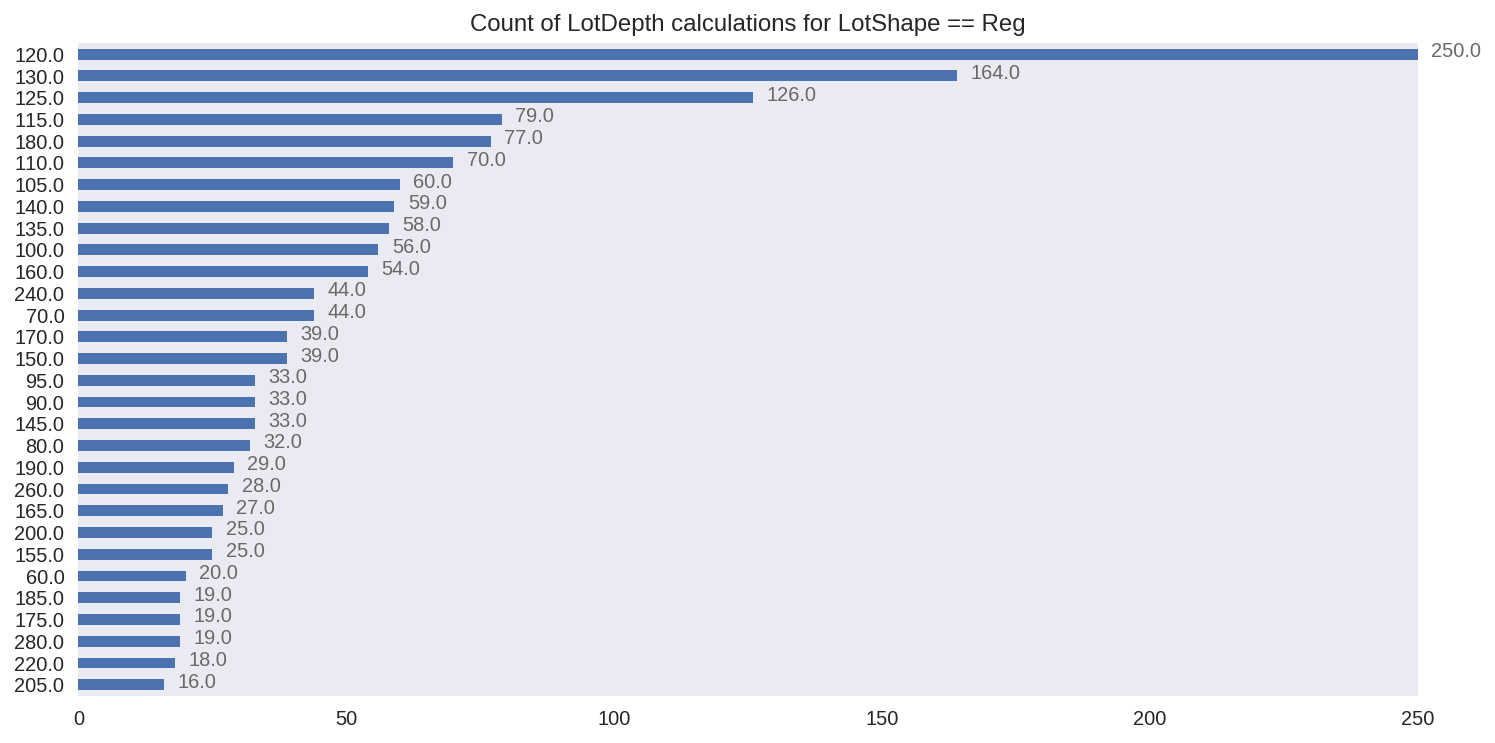

In [106]:
ax = plot_ann_barh(combined_df.loc[(combined_df["LotShape"] == "Reg"),"LotDepth"].value_counts().head(30), 
                   xlim=max(combined_df.loc[(combined_df["LotShape"] == "Reg"),"LotDepth"].value_counts()), 
                   title='Count of LotDepth calculations for LotShape == Reg')

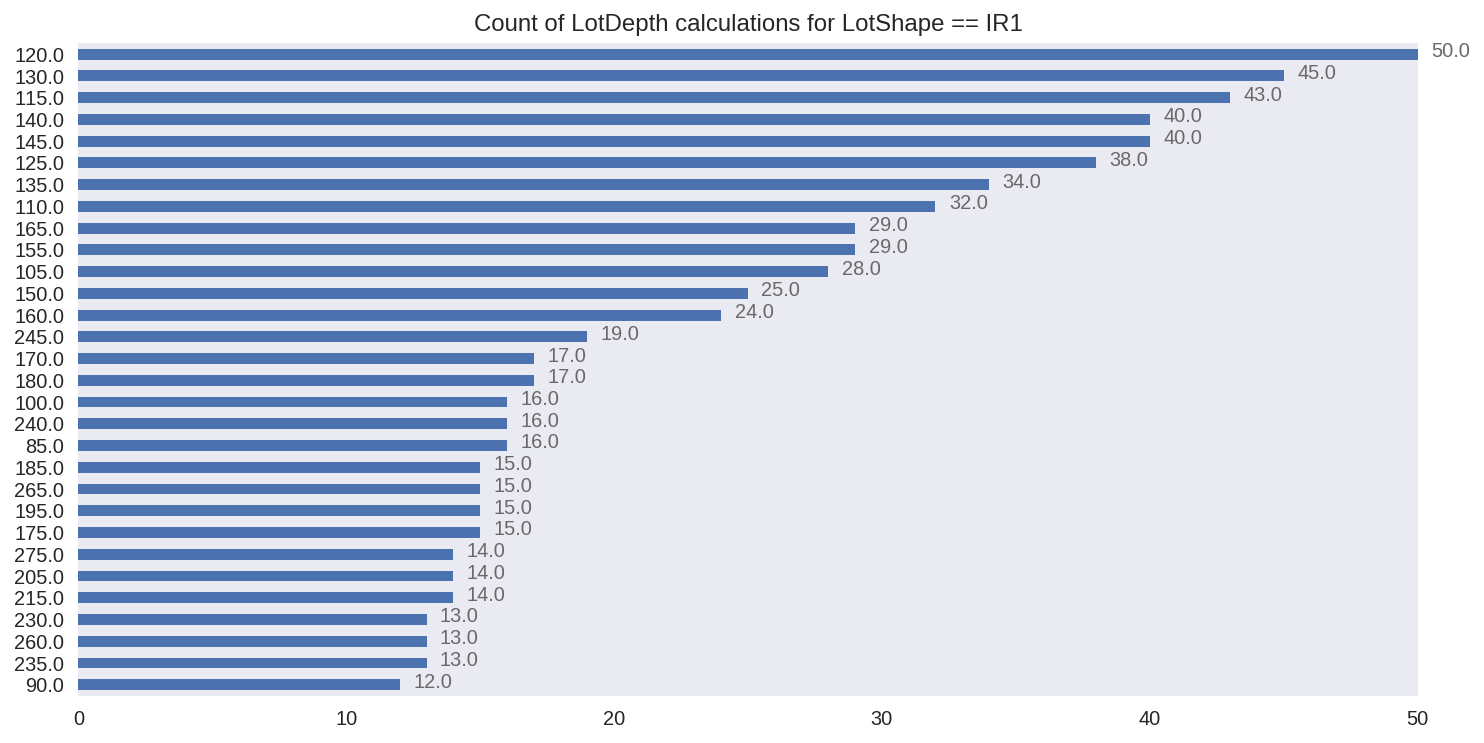

In [107]:
ax = plot_ann_barh(combined_df.loc[(combined_df["LotShape"] == "IR1"),"LotDepth"].value_counts().head(30), 
                   xlim=max(combined_df.loc[(combined_df["LotShape"] == "IR1"),"LotDepth"].value_counts()), 
                   title='Count of LotDepth calculations for LotShape == IR1')

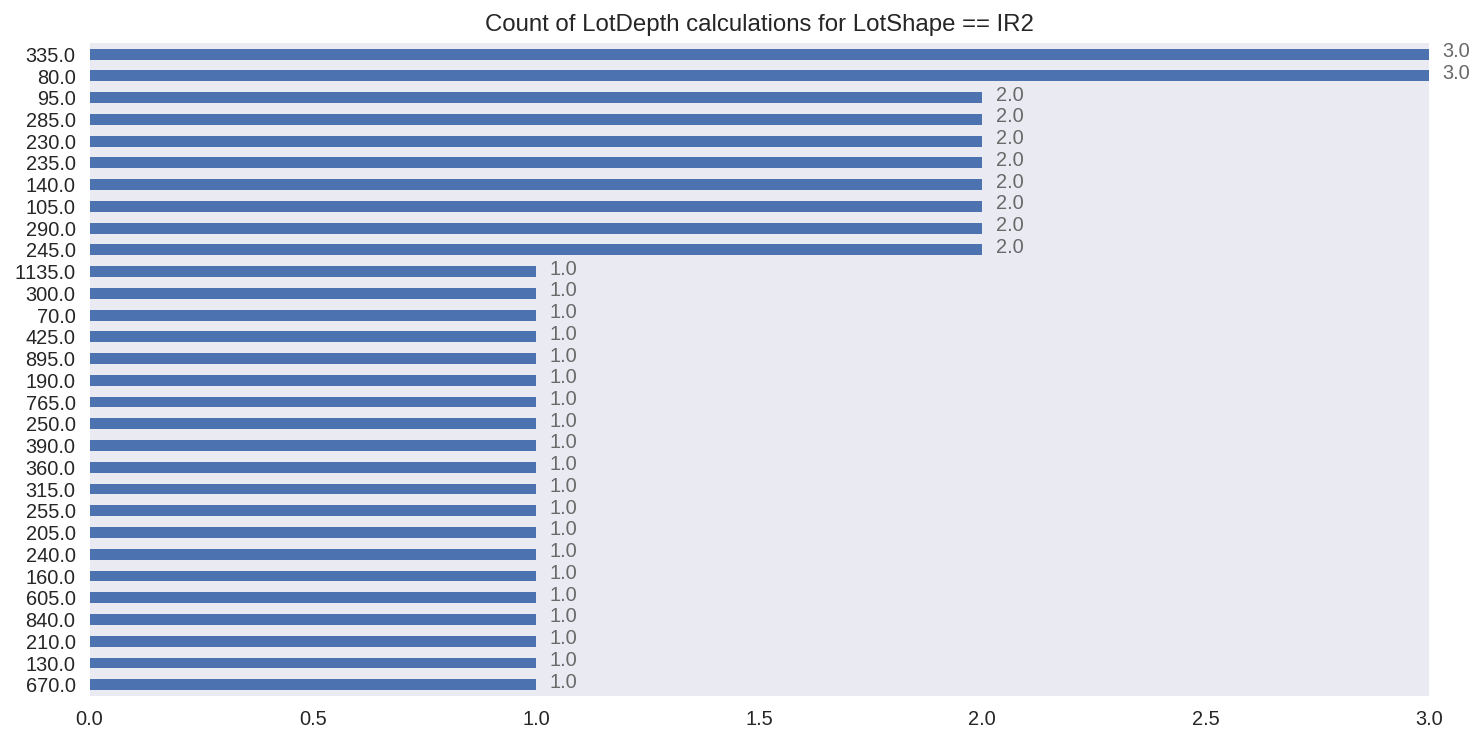

In [108]:
ax = plot_ann_barh(combined_df.loc[(combined_df["LotShape"] == "IR2"),"LotDepth"].value_counts().head(30), 
                   xlim=max(combined_df.loc[(combined_df["LotShape"] == "IR2"),"LotDepth"].value_counts()), 
                   title='Count of LotDepth calculations for LotShape == IR2')

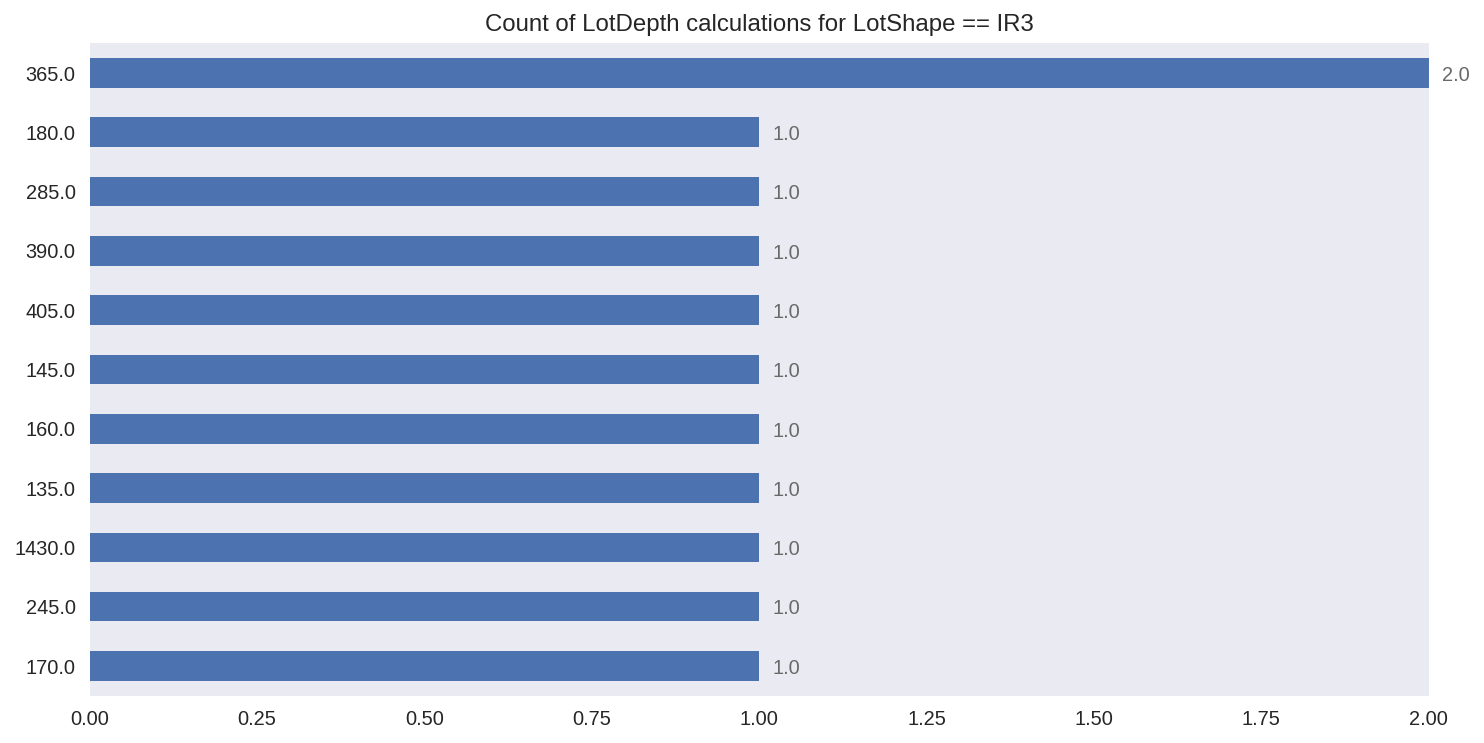

In [109]:
ax = plot_ann_barh(combined_df.loc[(combined_df["LotShape"] == "IR3"),"LotDepth"].value_counts().head(30), 
                   xlim=max(combined_df.loc[(combined_df["LotShape"] == "IR3"),"LotDepth"].value_counts()), 
                   title='Count of LotDepth calculations for LotShape == IR3')

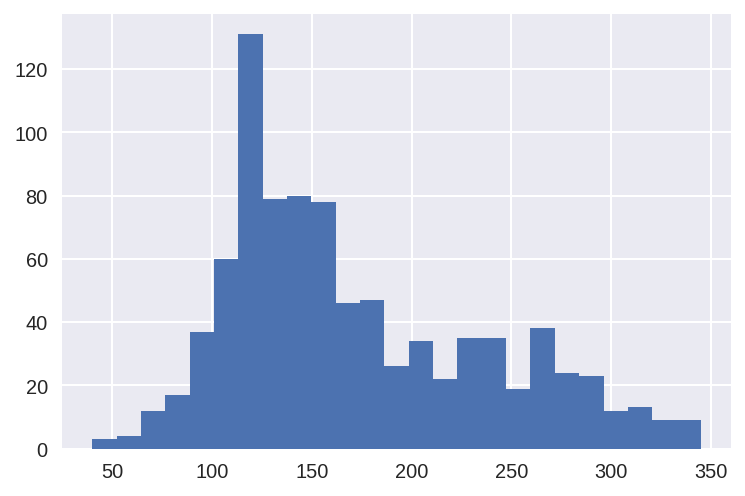

In [110]:
# From above plots it's clear that regularly shaped lots should have their depth calculation binned to 5ft resolution. 
# Irregular plots, not so clear.
combined_df.loc[((combined_df["LotShape"] == "IR1") & (combined_df["LotDepth"] < 350)),"LotDepth"].hist(bins=25)

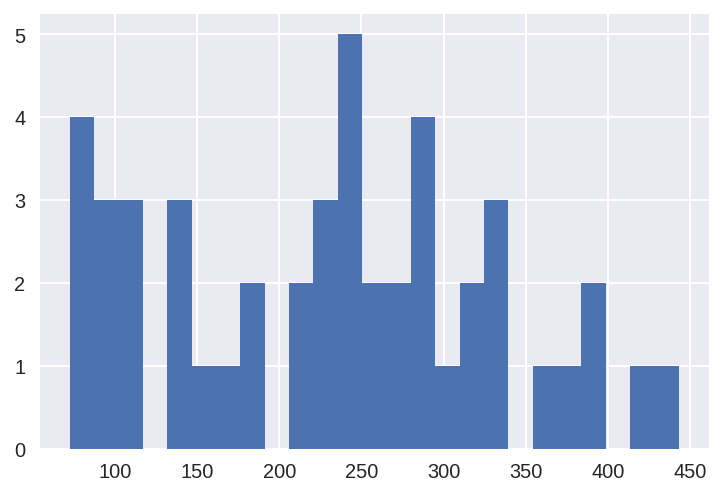

In [98]:
combined_df.loc[((combined_df["LotShape"] == "IR2") & (combined_df["LotDepth"] < 500)),"LotDepth"].hist(bins=25)

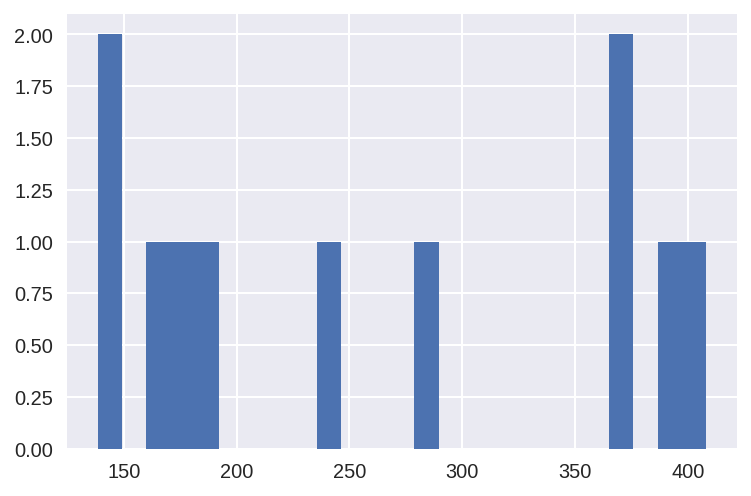

In [99]:
combined_df.loc[((combined_df["LotShape"] == "IR3") & (combined_df["LotDepth"] < 500)),"LotDepth"].hist(bins=25)

In [60]:
# Actually groupby neighborhood instead of lotarea for next-level imputation
# TODO: Instead of filling with median within the group, the median should be scaled by LotArea somehow first...
# TODO: Should add a binary feature to indicate imputed LotFrontage values.
combined_df["LotFrontage"] = combined_df.groupby(["Neighborhood","LotShape","LotConfig"])["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [61]:
missing_cnt = combined_df.isnull().sum()
missing = missing_cnt[missing_cnt > 0] 
print(missing)

LotFrontage    40
dtype: int64


In [62]:
# Down to 40, that's pretty good. Let's inspect...
combined_df.loc[combined_df["LotFrontage"].isnull(),("LotShape","LotFrontage","LotArea","LotConfig","LandContour","LandSlope","Neighborhood","HouseStyle")]

,LotShape,LotFrontage,LotArea,LotConfig,LandContour,LandSlope,Neighborhood,HouseStyle
Id,,,,,,,,
13,IR2,NaN,12968,Inside,Lvl,Gtl,Sawyer,1Story
51,IR2,NaN,13869,Corner,Lvl,Gtl,Gilbert,2Story
96,IR2,NaN,9765,Corner,Lvl,Gtl,Gilbert,2Story
127,IR1,NaN,4928,Inside,Lvl,Gtl,NPkVill,1Story
250,IR2,NaN,159000,CulDSac,Low,Sev,ClearCr,1.5Fin
308,IR1,NaN,7920,Inside,Lvl,Gtl,IDOTRR,1.5Fin
365,IR1,NaN,18800,FR2,Lvl,Gtl,NWAmes,2Story
385,IR2,NaN,53107,Corner,Low,Mod,ClearCr,2Story
422,IR1,NaN,16635,FR2,Lvl,Gtl,NWAmes,1Story


### Encode Categorical Data

### Normalization

## EDA

## Feature Engineering

## Simple Model Generation and Comparison